# 📓 Regresija 4 – Polinominė regresija su realiais duomenimis

Šiame užduočių rinkinyje dirbsime su **polinomine regresija** (kvadratine ir kubine), naudodami realų `seaborn` duomenų rinkinį.

## Tikslai:
1. Palyginti **tiesinę**, **kvadratinę** ir **kubinę** regresiją.
2. Suprasti, kada paprasta tiesinė regresija nėra pakankama.
3. Pamatyti realų pavyzdį su arbatpinigių duomenimis (`tips` dataset).


In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Pakraunam seaborn "tips" datasetą
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### 🔹 Užduotis 1
- Pažiūrėkite į duomenų rinkinį.
- Kokių kintamųjų jame yra?
- Kurie galėtų būti naudingi regresijai (X → Y)?

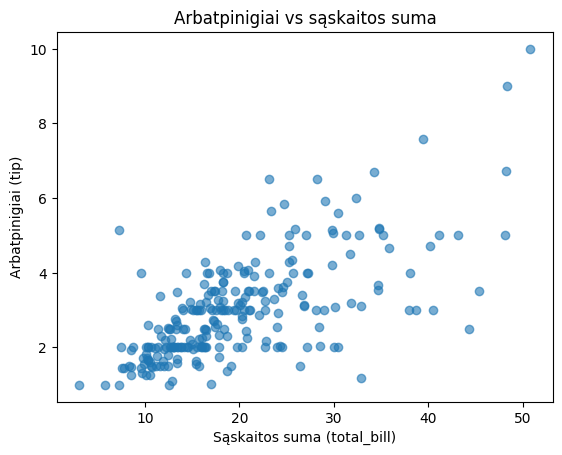

In [3]:
X = tips["total_bill"].values.reshape(-1, 1)
y = tips["tip"].values

plt.scatter(X, y, alpha=0.6)
plt.xlabel("Sąskaitos suma (total_bill)")
plt.ylabel("Arbatpinigiai (tip)")
plt.title("Arbatpinigiai vs sąskaitos suma")
plt.show()

### 🔹 Užduotis 2
1. Nubraižykite `total_bill` ir `tip` ryšį (scatter plot).  
2. Ar atrodo, kad ryšys yra **grynai tiesinis**?

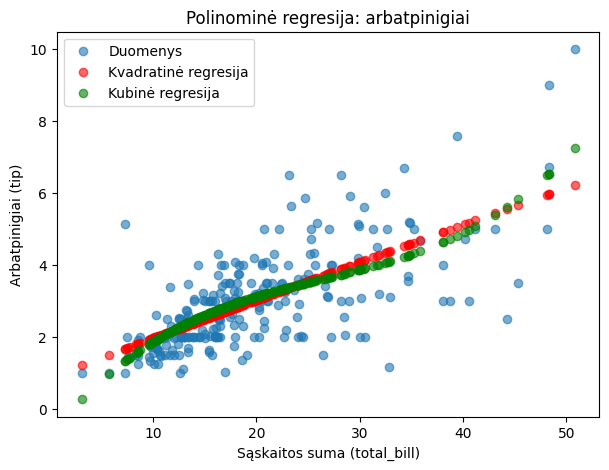

In [4]:
# Polinominė regresija (kvadratinė ir kubinė)
poly2 = PolynomialFeatures(degree=2)
X2 = poly2.fit_transform(X)
model2 = LinearRegression().fit(X2, y)
y2_pred = model2.predict(X2)

poly3 = PolynomialFeatures(degree=3)
X3 = poly3.fit_transform(X)
model3 = LinearRegression().fit(X3, y)
y3_pred = model3.predict(X3)

# Vizualizacija
plt.figure(figsize=(7,5))
plt.scatter(X, y, alpha=0.6, label="Duomenys")
plt.scatter(X, y2_pred, color="red", alpha=0.6, label="Kvadratinė regresija")
plt.scatter(X, y3_pred, color="green", alpha=0.6, label="Kubinė regresija")
plt.xlabel("Sąskaitos suma (total_bill)")
plt.ylabel("Arbatpinigiai (tip)")
plt.title("Polinominė regresija: arbatpinigiai")
plt.legend()
plt.show()

### 🔹 Užduotis 3
1. Palyginkite kvadratinės ir kubinės regresijos kreives.
2. Kuri, jūsų manymu, geriau aprašo ryšį tarp `total_bill` ir `tip`?
3. Ką darytumėte, jei duomenys turėtų dar kitokių netiesiškumų?

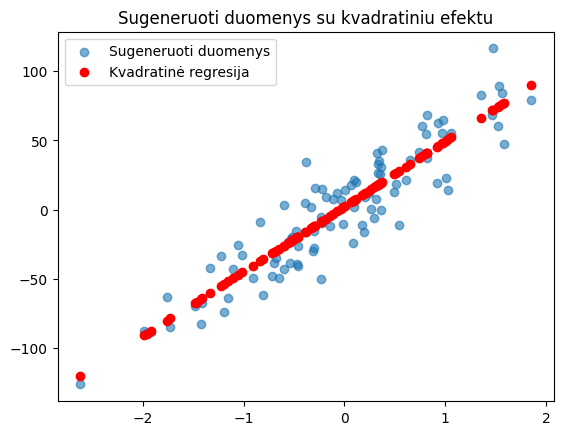

In [5]:
from sklearn.datasets import make_regression

# Sugeneruojame pseudo-duomenis su kvadratiniu efektu
X_syn, y_syn = make_regression(n_samples=100, n_features=1, noise=20, random_state=42)
y_syn = y_syn + 0.05*(X_syn[:,0]**2)  # pridedam kvadratinį komponentą

# Fit kvadratinį modelį
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_syn)
model = LinearRegression().fit(X_poly, y_syn)
y_pred = model.predict(X_poly)

plt.scatter(X_syn, y_syn, alpha=0.6, label="Sugeneruoti duomenys")
plt.scatter(X_syn, y_pred, color="red", label="Kvadratinė regresija")
plt.legend()
plt.title("Sugeneruoti duomenys su kvadratiniu efektu")
plt.show()

### 🔹 Užduotis 4
1. Pažiūrėkite į sintetinį pavyzdį.
2. Kodėl tiesinė regresija čia būtų netinkama?
3. Ar galima būtų pabandyti kubinę regresiją?


## 🔎 Modelių vertinimas: R², Adjusted R², RMSE, MAE, MAPE

Toliau apskaičiuosime klaidų metrikas trims modeliams (**tiesinis**, **kvadratinis**, **kubinis**), kad palygintume jų našumą.

**Formulės ir pastabos:**
- **RMSE** = \(\sqrt{\frac{1}{n} \sum (y - \hat{y})^2}\) — jautresnė išskirtinėms reikšmėms (outlier’iams).
- **MAE** = \(\frac{1}{n} \sum |y - \hat{y}|\) — aiški interpretacija vienetais (pvz., €).
- **MAPE** = \(\frac{100\%}{n} \sum \left|\frac{y - \hat{y}}{y}\right|\) — procentinė klaida (neapibrėžta, kai \(y=0\)).
- **R²** — paaiškintos dispersijos dalis; **Adjusted R²** koreguoja už kintamųjų skaičių:  
  \(R^2_{adj} = 1 - (1 - R^2) \cdot \frac{n-1}{n-p-1}\), kur *n* — mėginio dydis, *p* — regresoriaus laipsnis (be bias).


In [6]:

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# X, y jau apibrėžti ankstesnėse celėse (total_bill -> tip)
# Apsauga, jei vartotojas paleidžia šią celę pirmiau:
try:
    X
    y
except NameError:
    import seaborn as sns
    tips = sns.load_dataset("tips")
    X = tips["total_bill"].values.reshape(-1, 1)
    y = tips["tip"].values

def fit_poly_and_predict(X, y, degree):
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    Xd = poly.fit_transform(X)
    model = LinearRegression().fit(Xd, y)
    y_hat = model.predict(Xd)
    return model, y_hat, Xd.shape[1]-1  # p = features without bias

def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def adjusted_r2(r2, n, p):
    # p = prediktorių skaičius (be bias termino), n = imties dydis
    if n - p - 1 <= 0:
        return np.nan
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

metrics_rows = []
results = {}

for deg, name in [(1, "Tiesinė (deg=1)"), (2, "Kvadratinė (deg=2)"), (3, "Kubinė (deg=3)")]:
    model, y_hat, p = fit_poly_and_predict(X, y, degree=deg)
    n = len(y)
    r2 = r2_score(y, y_hat)
    adj = adjusted_r2(r2, n, p)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    mae = mean_absolute_error(y, y_hat)
    mp = mape(y, y_hat)
    metrics_rows.append([name, r2, adj, rmse, mae, mp, p])
    results[name] = dict(r2=r2, adj_r2=adj, rmse=rmse, mae=mae, mape=mp, p=p)

df_metrics = pd.DataFrame(metrics_rows, columns=["Modelis", "R²", "Adjusted R²", "RMSE", "MAE", "MAPE (%)", "p (kintam.)"])
df_metrics.sort_values(by="RMSE", inplace=True)
df_metrics.reset_index(drop=True, inplace=True)
df_metrics


,Modelis,R²,Adjusted R²,RMSE,MAE,MAPE (%),p (kintam.)
0,Kubinė (deg=3),0.472873,0.466284,1.002509,0.733958,27.448364,3
1,Kvadratinė (deg=2),0.456637,0.452128,1.017831,0.744753,27.880674,2
2,Tiesinė (deg=1),0.456617,0.454371,1.017850,0.745825,27.938270,1



### 💬 Interpretacija
- Kuris modelis turi **mažiausią RMSE/MAE**? Ar jis nebūtinai turi didžiausią R²?
- Ar **Adjusted R²** sutinka su jūsų pasirinkimu (ar nebaudžia per daug už papildomą sudėtingumą)?
- Ar **MAPE** čia prasmingas (ar nėra reikšmių su \(y=0\))? Kaip interpretuotumėte procentinę klaidą?  
(Pvz., *„vidutiniškai klystame ~X % nuo tikros reikšmės“*)



## 🧪 Sintetinis pavyzdys: metrikų palyginimas

Pakartokime tuos pačius skaičiavimus sintetiniams duomenims su kvadratiniu efektu.


In [7]:

from sklearn.datasets import make_regression

# Generuojame duomenis su kvadratiniu komponentu
X_syn, y_syn = make_regression(n_samples=120, n_features=1, noise=20, random_state=7)
y_syn = y_syn + 0.06 * (X_syn[:, 0] ** 2)

rows = []
for deg, name in [(1, "Tiesinė (deg=1)"), (2, "Kvadratinė (deg=2)"), (3, "Kubinė (deg=3)")]:
    model, y_hat, p = fit_poly_and_predict(X_syn, y_syn, degree=deg)
    n = len(y_syn)
    r2 = r2_score(y_syn, y_hat)
    adj = adjusted_r2(r2, n, p)
    rmse = np.sqrt(mean_squared_error(y_syn, y_hat))
    mae = mean_absolute_error(y_syn, y_hat)
    mp = mape(y_syn, y_hat)
    rows.append([name, r2, adj, rmse, mae, mp, p])

df_syn = pd.DataFrame(rows, columns=["Modelis", "R²", "Adjusted R²", "RMSE", "MAE", "MAPE (%)", "p (kintam.)"])
df_syn.sort_values(by="RMSE", inplace=True)
df_syn.reset_index(drop=True, inplace=True)
df_syn


,Modelis,R²,Adjusted R²,RMSE,MAE,MAPE (%),p (kintam.)
0,Kubinė (deg=3),0.315944,0.298253,20.371154,16.212938,160.524210,3
1,Kvadratinė (deg=2),0.314183,0.302459,20.397357,16.219561,157.677568,2
2,Tiesinė (deg=1),0.305446,0.299560,20.526872,16.385878,153.394214,1



## 📊 Gražesnės lentelės su paryškinimu

Naudosime `pandas.DataFrame.style` galimybes, kad vizualiai pamatytume, kuris modelis turi geriausias metrikas (mažiausia klaida, didžiausias R²).


In [8]:

def highlight_best(df):
    styles = pd.DataFrame("", index=df.index, columns=df.columns)
    # Didžiausias R² ir Adjusted R²
    for col in ["R²", "Adjusted R²"]:
        max_idx = df[col].idxmax()
        styles.loc[max_idx, col] = "background-color: green"
    # Mažiausi RMSE, MAE, MAPE
    for col in ["RMSE", "MAE", "MAPE (%)"]:
        min_idx = df[col].idxmin()
        styles.loc[min_idx, col] = "background-color: green"
    return styles

df_metrics.style.format(precision=3).apply(highlight_best, axis=None)


,Modelis,R²,Adjusted R²,RMSE,MAE,MAPE (%),p (kintam.)
0,Kubinė (deg=3),0.473,0.466,1.003,0.734,27.448,3
1,Kvadratinė (deg=2),0.457,0.452,1.018,0.745,27.881,2
2,Tiesinė (deg=1),0.457,0.454,1.018,0.746,27.938,1



## 🧾 Train/Test Split

Iki šiol skaičiavome klaidas **toje pačioje imtyje (in-sample)**.  
Kad patikrintume, ar modelis generalizuoja, padalinsime duomenis į **train/test** ir paskaičiuosime klaidas testiniuose duomenyse.


In [9]:

# ---- Importai
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ---- Pagalbinės funkcijos
def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def highlight_best(df: pd.DataFrame):
    """Paryškina didžiausius R² (bet sugauna tiek 'R²', tiek 'R2') ir mažiausius RMSE/MAE/MAPE stulpelius,
    nepriklausomai ar jie 'test' ar ne."""
    styles = pd.DataFrame("", index=df.index, columns=df.columns)
    # R2 stulpeliai (pvz., 'R² (test)' arba 'R2(test)' ir pan.)
    r2_cols = [c for c in df.columns if ("R²" in c) or ("R2" in c)]
    for col in r2_cols:
        styles.loc[df[col].idxmax(), col] = "background-color: lightgreen"
    # Klaidos stulpeliai (mažiau = geriau)
    for key in ["RMSE", "MAE", "MAPE"]:
        cols = [c for c in df.columns if key in c]
        for col in cols:
            styles.loc[df[col].idxmin(), col] = "background-color: lightgreen"
    return styles

# ---- Duomenys
tips = sns.load_dataset("tips")
X = tips["total_bill"].values.reshape(-1, 1)
y = tips["tip"].values

# ---- Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# ---- Modeliavimas ir metrikos test rinkinyje
rows_split = []
for deg, name in [(1, "Tiesinė (deg=1)"),
                  (2, "Kvadratinė (deg=2)"),
                  (3, "Kubinė (deg=3)")]:
    poly = PolynomialFeatures(degree=deg, include_bias=True)
    X_train_d = poly.fit_transform(X_train)
    X_test_d  = poly.transform(X_test)

    model = LinearRegression().fit(X_train_d, y_train)
    y_pred = model.predict(X_test_d)

    r2  = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)  
    mae  = mean_absolute_error(y_test, y_pred)
    mp   = mape(y_test, y_pred)

    rows_split.append([name, r2, rmse, mae, mp])

df_split = pd.DataFrame(
    rows_split,
    columns=["Modelis", "R² (test)", "RMSE (test)", "MAE (test)", "MAPE (%) (test)"]
)

# Pasirenkama: rikiuoti pagal mažiausią RMSE (test)
df_split = df_split.sort_values(by="RMSE (test)").reset_index(drop=True)

# ---- Atvaizdavimas su paryškinimu
df_split.style.format(precision=3).apply(highlight_best,  axis=None)

,Modelis,R² (test),RMSE (test),MAE (test),MAPE (%) (test)
0,Kvadratinė (deg=2),0.440,0.745,0.652,25.865
1,Tiesinė (deg=1),0.440,0.745,0.652,25.871
2,Kubinė (deg=3),0.295,0.938,0.698,28.868


,Modelis,R² (test),RMSE (test),MAE (test),MAPE (%) (test)
0,Tiesinė (deg=1),0.545,0.569,0.621,26.395
1,Kvadratinė (deg=2),0.530,0.587,0.640,27.368
2,Kubinė (deg=3),0.509,0.614,0.619,26.778


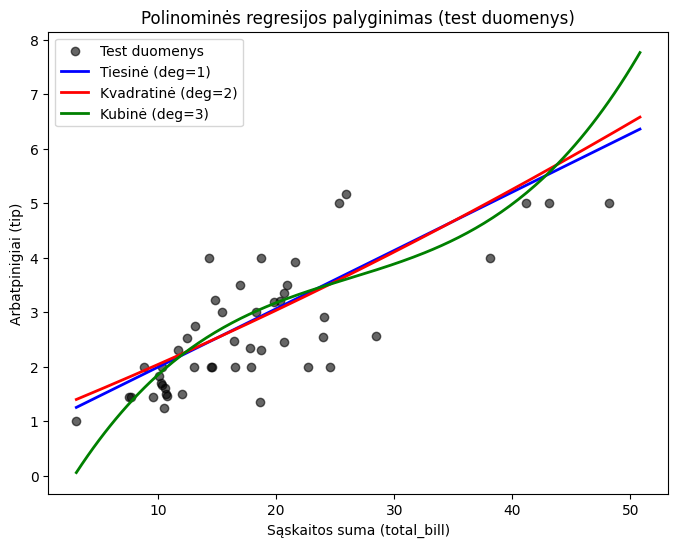

In [10]:
# ---- Importai
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ---- Pagalbinės funkcijos
def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def highlight_best(df: pd.DataFrame):
    styles = pd.DataFrame("", index=df.index, columns=df.columns)
    # R² stulpeliai
    r2_cols = [c for c in df.columns if ("R²" in c) or ("R2" in c)]
    for col in r2_cols:
        styles.loc[df[col].idxmax(), col] = "background-color: lightgreen"
    # Klaidos stulpeliai
    for key in ["RMSE", "MAE", "MAPE"]:
        cols = [c for c in df.columns if key in c]
        for col in cols:
            styles.loc[df[col].idxmin(), col] = "background-color: lightgreen"
    return styles

# ---- Duomenys
tips = sns.load_dataset("tips")
X = tips["total_bill"].values.reshape(-1, 1)
y = tips["tip"].values

# ---- Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# ---- Modelių palyginimas
rows_split = []
pred_curves = {}  # saugosime prognozes vizualizacijai

# X reikšmės, per kurias braižysime kreives
x_range = np.linspace(X.min(), X.max(), 200).reshape(-1,1)

for deg, name, color in [(1, "Tiesinė (deg=1)", "blue"),
                         (2, "Kvadratinė (deg=2)", "red"),
                         (3, "Kubinė (deg=3)", "green")]:
    poly = PolynomialFeatures(degree=deg, include_bias=True)
    X_train_d = poly.fit_transform(X_train)
    X_test_d  = poly.transform(X_test)

    model = LinearRegression().fit(X_train_d, y_train)
    y_pred = model.predict(X_test_d)

    # Metrikos
    r2  = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    mae  = mean_absolute_error(y_test, y_pred)
    mp   = mape(y_test, y_pred)

    rows_split.append([name, r2, rmse, mae, mp])

    # Prognozės per visą X diapazoną
    x_range_d = poly.transform(x_range)
    pred_curves[name] = (x_range, model.predict(x_range_d), color)

df_split = pd.DataFrame(
    rows_split,
    columns=["Modelis", "R² (test)", "RMSE (test)", "MAE (test)", "MAPE (%) (test)"]
)

# Lentelė
display(df_split.style.format(precision=3).apply(highlight_best, axis=None))

# ---- Vizualizacija: test duomenys + kreivės
plt.figure(figsize=(8,6))
plt.scatter(X_test, y_test, color="black", alpha=0.6, label="Test duomenys")

for name, (xx, yy, col) in pred_curves.items():
    plt.plot(xx, yy, color=col, label=name, linewidth=2)

plt.xlabel("Sąskaitos suma (total_bill)")
plt.ylabel("Arbatpinigiai (tip)")
plt.title("Polinominės regresijos palyginimas (test duomenys)")
plt.legend()
plt.show()


## 🤖 Automatinis modelio laipsnio parinkimas (AIC/BIC ir k-fold CV)

Polinominė regresija gali būti įvairių laipsnių. Pasirinksime „geriausią“ naudodami:
- **AIC** ir **BIC** – informacijos kriterijai (baudžia už modelio sudėtingumą).
- **k-fold Cross-Validation** – praktinis būdas įvertinti modelio prognozavimo tikslumą.


In [11]:

# from sklearn.model_selection import cross_val_score, KFold

# def compute_aic_bic(y_true, y_pred, p):
#     n = len(y_true)
#     resid = y_true - y_pred
#     rss = np.sum(resid**2)
#     sigma2 = rss / n
#     # log-likelihood (normalusis pasiskirstymas)
#     ll = -0.5*n*(np.log(2*np.pi*sigma2) + 1)
#     aic = 2*p - 2*ll
#     bic = p*np.log(n) - 2*ll
#     return aic, bic

# rows_auto = []
# cv = KFold(n_splits=10, shuffle=True, random_state=42)

# for deg in range(1, 10):
#     poly = PolynomialFeatures(degree=deg)
#     Xd = poly.fit_transform(X)
#     model = LinearRegression().fit(Xd, y)
#     y_hat = model.predict(Xd)
#     p = Xd.shape[1]-1
    
#     aic, bic = compute_aic_bic(y, y_hat, p)
#     # Cross-validation RMSE (neg_mean_squared_error -> sqrt)
#     scores = cross_val_score(LinearRegression(), Xd, y, cv=cv, scoring="neg_mean_squared_error")
#     rmse_cv = np.mean(np.sqrt(-scores))
#     rows_auto.append([deg, p, aic, bic, rmse_cv])

# df_auto = pd.DataFrame(rows_auto, columns=["Laipsnis", "p (kintam.)", "AIC", "BIC", "CV RMSE"])
# df_auto.style.format(precision=2).apply(highlight_best, axis=None)


In [12]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# -----------------------------
# 1) DATA (edit feature_cols as you wish)
# -----------------------------
tips = sns.load_dataset("tips")
y = tips["tip"].values
feature_cols = ["total_bill", "size"]   # <--- add/remove columns here
X_df = tips[feature_cols]

# -----------------------------
# 2) DEGREE SELECTION with CV
# -----------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)

pipe = Pipeline([
    ("poly", PolynomialFeatures(include_bias=True)),  # no bias; handled by model
    ("scaler", StandardScaler(with_mean=False)),       # sparse-friendly; safe for poly
    ("lin", LinearRegression())
])

param_grid = {
    "poly__degree": [1, 2, 3, 4, 5, 6, 7],
    "poly__interaction_only": [True, False],  # try with/without interactions
}

gcv = GridSearchCV(
    pipe,
    param_grid=param_grid,
    # scoring="neg_root_mean_squared_error",  
    scoring="r2",  
    cv=cv,
    n_jobs=-1
)
gcv.fit(X_df, y)

best_degree = gcv.best_params_["poly__degree"]
best_interact = gcv.best_params_["poly__interaction_only"]
best_cv_rmse = -gcv.best_score_
print(f"[Degree Search] Best degree={best_degree}, interaction_only={best_interact}, CV RMSE={best_cv_rmse:.3f}")

# -----------------------------
# 3) RE-FIT best polynomial and run LassoCV for feature selection
# -----------------------------
poly_best = PolynomialFeatures(degree=best_degree, include_bias=False, interaction_only=best_interact)
X_poly = poly_best.fit_transform(X_df)

# LassoCV will zero-out useless terms and keep the signal
lasso = LassoCV(cv=cv, random_state=42, alphas=100)
lasso.fit(StandardScaler(with_mean=False).fit_transform(X_poly), y)

feature_names = poly_best.get_feature_names_out(feature_cols)
coefs = pd.Series(lasso.coef_, index=feature_names)

# Keep non-zero (selected) features, sort by importance
selected = coefs[coefs != 0].sort_values(key=np.abs, ascending=False)

print("\n[Feature Recommendation]")
print(f"Recommended polynomial degree: {best_degree} (interaction_only={best_interact})")
print("Selected terms by LassoCV (non-zero coefficients, sorted by |coef|):")
print(selected.round(4).head(20))  # top 20 for brevity

# -----------------------------
# 4) Final evaluation on CV with the sparse model
# -----------------------------
def rmse(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

sparse_pipe = Pipeline([
    ("poly", poly_best),
    ("scaler", StandardScaler(with_mean=True)),
    ("lasso", LassoCV(cv=cv, random_state=42))
])
cv_scores = cross_val_score(
    sparse_pipe, X_df, y, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1
)
print(f"\n[Sparse Model CV] RMSE: mean={-cv_scores.mean():.3f}, std={cv_scores.std():.3f}")

# -----------------------------
# 5) Optional: nice summary table vs plain LinearRegression on same degree
# -----------------------------
plain_lin = Pipeline([
    ("poly", poly_best),
    ("scaler", StandardScaler(with_mean=False)),
    ("lin", LinearRegression())
])

lin_rmse = -cross_val_score(plain_lin, X_df, y, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1).mean()
sparse_rmse = -cv_scores.mean()

summary = pd.DataFrame({
    "Model": ["Poly + LinearRegression", "Poly + LassoCV (selected)"],
    "Degree": [best_degree, best_degree],
    "interaction_only": [best_interact, best_interact],
    "CV RMSE": [lin_rmse, sparse_rmse],
})
print("\n[Summary]")
print(summary.round(3))

[Degree Search] Best degree=1, interaction_only=True, CV RMSE=-0.407

[Feature Recommendation]
Recommended polynomial degree: 1 (interaction_only=True)
Selected terms by LassoCV (non-zero coefficients, sorted by |coef|):
total_bill    0.8160
size          0.1751
dtype: float64

[Sparse Model CV] RMSE: mean=1.025, std=0.142

[Summary]
                       Model  Degree  interaction_only  CV RMSE
0    Poly + LinearRegression       1              True    1.025
1  Poly + LassoCV (selected)       1              True    1.025



# ✅ Modelio prielaidų tikrinimas

Klasikinė tiesinė regresija (įskaitant polinominę, kai funkciją išplečiame X, X², X³ ir pan.) remiasi keliomis svarbiomis **prielaidomis**. Žemiau – praktiniai patikrinimai su `tips` duomenų rinkiniu ir **kvadratiniu modeliu** (`total_bill → tip`).

**Pagrindinės prielaidos:**
1. **Linijiškumas**: tikrasis ryšys tarp transformuotų kintamųjų (pvz., X, X²) ir Y yra linijinis koeficientų prasme.
2. **Nešališka specifikacija**: modelyje netrūksta svarbių kintamųjų, nėra nereikalingų transformacijų.
3. **Klaidų normalumas**: residualai (paklaidos) yra apytiksliai normalūs (reikšminga inferencijai – p‑reikšmėms, CI).
4. **Homoskedastiškumas**: klaidų dispersija yra **pastovi** visame X diapazone.
5. **Neautokoreliuotos klaidos**: residualai tarpusavyje nekoreliuoja (ypač svarbu laiko eilutėms).
6. **Nepriklausomi stebiniai**: stebiniai nepriklausomi vienas nuo kito.


In [13]:

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy import stats

# Duomenys
tips = sns.load_dataset("tips")
X = tips["total_bill"].values.reshape(-1, 1)
y = tips["tip"].values

# Kvadratinis modelis
poly2 = PolynomialFeatures(degree=2, include_bias=False)
X2 = poly2.fit_transform(X)
model2 = LinearRegression().fit(X2, y)
y_hat = model2.predict(X2)
resid = y - y_hat

len(y), X2.shape[1] - 1  # (n, p)


(244, 1)


## 🌐 Normalumo prielaida (residualai ~ Normal)

**Kodėl svarbu?** Normalumas reikalingas **parametrinei inferencijai** (p‑reikšmėms, CI) ir patikimesniam koeficientų standartinių paklaidų vertinimui. Prognozėms nebūtinai kritiška, bet **didelės asimetrijos** ar **stori uodegai** gali iškreipti išvadas.

**Kaip tikrinti?**
- **Histogramą** su „varpelio“ forma.
- **Q–Q plot** (kvantilių‑kvantilių grafikas): taškai turėtų gulėti ant (ar netoli) tiesės.


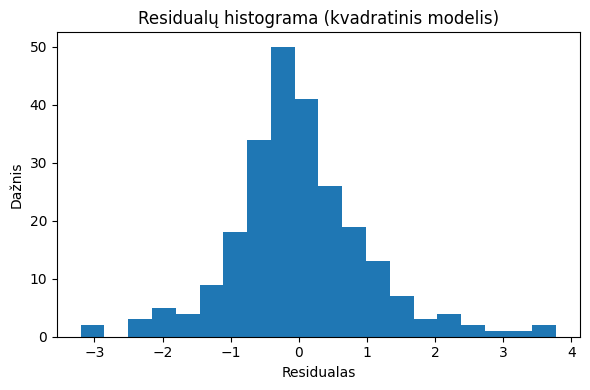

In [14]:

# Histogram (residualų pasiskirstymas)
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(resid, bins=20)
plt.title("Residualų histograma (kvadratinis modelis)")
plt.xlabel("Residualas")
plt.ylabel("Dažnis")
plt.tight_layout()
plt.show()


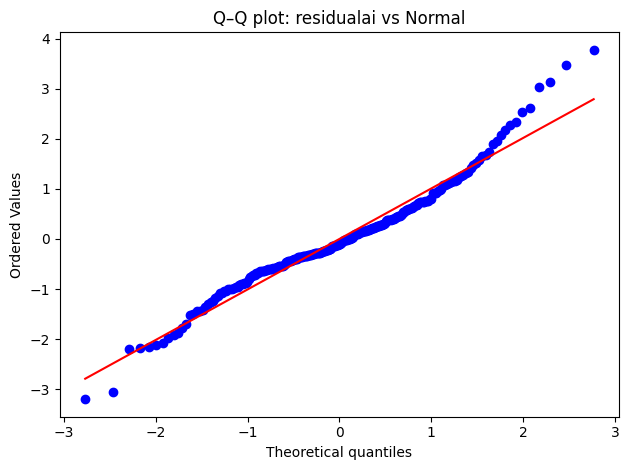

In [15]:

# Q-Q plot
_ = stats.probplot(resid, dist="norm", plot=plt)
plt.title("Q–Q plot: residualai vs Normal")
plt.tight_layout()
plt.show()



## 📈 Homoskedastiškumas vs heteroskedastiškumas

**Homoskedastiškumas** – klaidų dispersija pastovi visame X (arba prognozuotų reikšmių) diapazone.  
**Heteroskedastiškumas** – klaidų dispersija **kinta** (dažnai didėja su X). Tai gali lemti **neefektyvius** (bet vis dar nešališkus) OLS įverčius ir **netikslias** standartines paklaidas (per mažas arba per dideles).

**Kaip tikrinti?**
- Brėžti **residualai vs prognozuotą reikšmę** (`resid` prieš `y_hat`): ieškoti „vokelio“ formos.
- Jei „vokelis“ platėja didėjant `y_hat`, turime heteroskedastiškumo požymių.


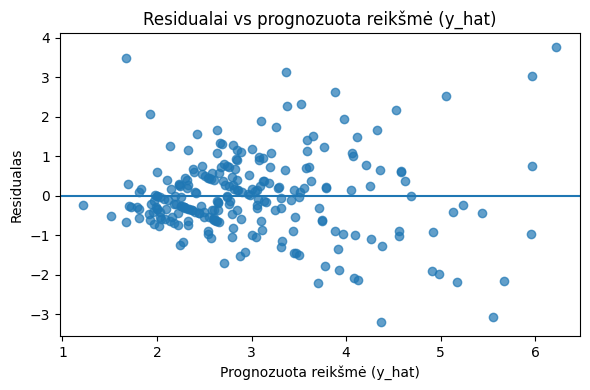

In [16]:
# Pastaba: Realiai duomenyse mažų nuokrypių visada bus, bet kol nėra akivaizdaus sistemingo didėjimo ar mažėjimo → prielaida homoskedastiškumui nėra pažeista.
plt.figure(figsize=(6,4))
plt.scatter(y_hat, resid, alpha=0.7)
plt.axhline(0)
plt.title("Residualai vs prognozuota reikšmė (y_hat)")
plt.xlabel("Prognozuota reikšmė (y_hat)")
plt.ylabel("Residualas")
plt.tight_layout()
plt.show()



### 🔬 Pavyzdys: dirbtinis heteroskedastiškumas

Sukursime sintetinius duomenis, kur klaidų dispersija **didėja** didėjant X (multiplikatyvus triukšmas).


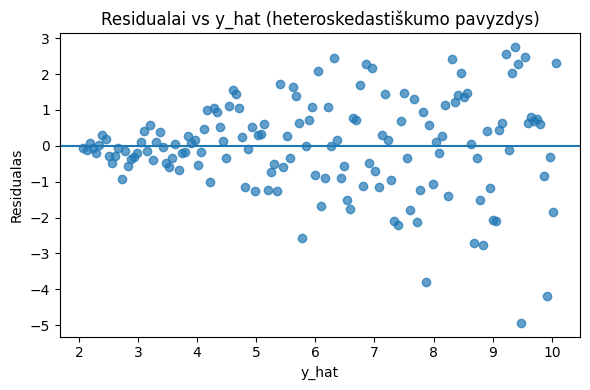

In [17]:

rng = np.random.default_rng(0)
x_demo = np.linspace(0, 10, 150)
y_true = 2 + 0.8 * x_demo
eps = rng.normal(0, 0.2 * (1 + x_demo))  # dispersija auga su x
y_demo = y_true + eps

# Tiesinė regresija iliustracijai
Xd = x_demo.reshape(-1,1)
mdl = LinearRegression().fit(Xd, y_demo)
yhat_demo = mdl.predict(Xd)
res_demo = y_demo - yhat_demo

plt.figure(figsize=(6,4))
plt.scatter(yhat_demo, res_demo, alpha=0.7)
plt.axhline(0)
plt.title("Residualai vs y_hat (heteroskedastiškumo pavyzdys)")
plt.xlabel("y_hat")
plt.ylabel("Residualas")
plt.tight_layout()
plt.show()



## 🔁 Autokoreliacija ir Durbin–Watson (DW) testas

**Autokoreliacija** – kai residualai tarpusavyje susiję (pvz., laiko eilutėse). Tai pažeidžia nepriklausomumo prielaidą ir gali iškreipti inferenciją.

**Durbin–Watson** statistika apytiksliai matuoja 1‑os eilės autokoreliaciją:
- Reikšmės intervale **[0, 4]**.
- **~2** → autokoreliacijos nėra (residualai atsitiktiniai, „balti triukšmai“).
- **< 2** → **teigiama** autokoreliacija (residualai linkę tęstis, linkę sekti vienas kitą ta pačia kryptimi).
- **> 2** → **neigiama** autokoreliacija (residualai linkę „šokinėti“ – vienas aukštyn, kitas žemyn).


In [18]:

# Durbin–Watson skaičiavimas (rankiniu būdu)
num = np.sum(np.diff(resid)**2)
den = np.sum(resid**2)
dw = num / den
dw


np.float64(2.1484034665006195)


### 🧭 Ką daryti, jei prielaidos pažeidžiamos?

- **Normalumas**: naudokite **robust** metodus, transformacijas (pvz., log), arba „bootstrap“ CI.
- **Heteroskedastiškumas**: taikykite **HC (White) robust** standartines paklaidas, transformuokite kintamuosius, modeliuokite dispersiją (pvz., `QuantileRegression`, `GLM` su tinkamu šeimos/link).
- **Autokoreliacija**: naudokite **ARIMA/ARIMAX**, **GLS**, **Newey–West** paklaidas, įtraukite lagus.
- **Nelinijiškumas**: pridėkite polinomų/ sąveikų, **spline**, **GAM**, ar perjunkite į nelinijinius modelius.

> Praktikoje svarbu atskirti: **inferencijos tikslai** (reikia prielaidų) vs **prognozavimo tikslai** (didesnis dėmesys klaidoms out-of-sample).
